In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
n = 10
trial = 200000
q_star = np.random.normal(0, 1, n)
additional_q_star = np.random.normal(0, 0.01, (trial, n))

after_q_star = q_star + np.sum(additional_q_star, axis=0)

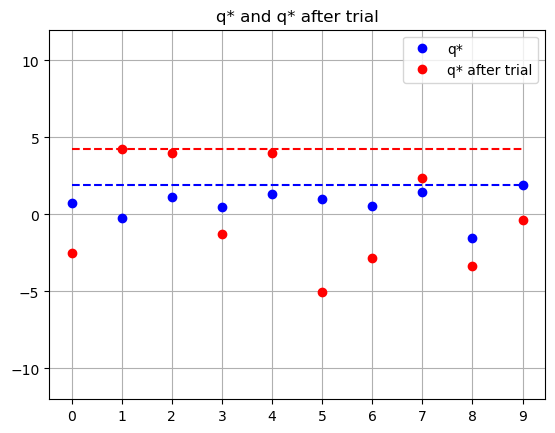

In [29]:
plt.plot(q_star, 'bo')
plt.plot(after_q_star, 'ro')
plt.plot(range(0, n), max(q_star) * np.ones(n), 'b--')
plt.plot(range(0, n), max(after_q_star) * np.ones(n), 'r--')

plt.title('q* and q* after trial')
plt.legend(['q*', 'q* after trial'])
plt.ylim(-12, 12)
plt.xticks(range(0, n))
plt.grid()
plt.show()

In [30]:
def bandit_EG(q_star, epsilon, trial):
    q_star = q_star.copy()
    n = len(q_star)
    Q = np.zeros(n)
    N = np.zeros(n)

    action_log = []
    reward_log = []

    for step in range(trial):
        if epsilon < np.random.random():
            a = np.argmax(Q)
            action_log.append(a)
        else:
            a = np.random.randint(n)
            action_log.append(a)
        
        r = np.random.normal(q_star[a], 1)
        reward_log.append(r)
        N[a] += 1
        Q[a] += (r-Q[a]) * 0.1

        q_star += additional_q_star[step]
    
    return action_log, reward_log

In [31]:
def bandit_POS(q_star, trial, q0=0):
    q_star = q_star.copy()
    n = len(q_star)
    Q = np.full(n, q0, dtype=float)

    action_log = []
    reward_log = []

    for step in range(trial):
        a = np.argmax(Q)
        action_log.append(a)
        
        r = np.random.normal(q_star[a], 1)
        reward_log.append(r)
        Q[a] += (r-Q[a]) * 0.1

        q_star += additional_q_star[step]
    
    return action_log, reward_log

In [32]:
def bandit_UCB(q_star, trial, c=0):
    q_star = q_star.copy()
    n = len(q_star)
    Q = np.zeros(n)
    N = np.zeros(n)

    action_log = []
    reward_log = []

    for step in range(trial):
        a = np.argmax(Q + c * np.sqrt(np.log(step+1) / (N+0.001)))
        action_log.append(a)
        
        r = np.random.normal(q_star[a], 1)
        reward_log.append(r)
        N[a] += 1
        Q[a] += (r-Q[a]) / N[a]

        q_star += additional_q_star[step]
    
    return action_log, reward_log

In [33]:
def bandit_GRAD(q_star, alpha, trial, comp=True):
    q_star = q_star.copy()
    n = len(q_star)
    H = np.zeros(n)

    action_log = []
    reward_log = []

    average_reward = 0

    for step in range(trial):
        H -= np.max(H)
        a_table = np.exp(H) / np.sum(np.exp(H))
        a = np.random.choice(n, p=a_table)
        action_log.append(a)
        r = np.random.normal(q_star[a], 1)
        reward_log.append(r)

        average_reward += (r - average_reward) / (step+1)

        H -= alpha * (r - comp * average_reward) * a_table
        H[a] += alpha * (r - comp * average_reward) * (1 - a_table[a])

        q_star += additional_q_star[step]

    return action_log, reward_log

In [34]:
eps_greedy = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]
eps_greedy_reward = list(map(lambda eps: np.mean(bandit_EG(q_star, eps, trial)[1][100000:]), eps_greedy))

positive_Q = [1/4, 1/2, 1, 2, 4]
positive_Q_reward = list(map(lambda q0: np.mean(bandit_POS(q_star, trial, q0)[1][100000:]), positive_Q))

UCB = [1/16, 1/8, 1/4, 1/2, 1, 2, 4]
UCB_reward = list(map(lambda c: np.mean(bandit_UCB(q_star, trial, c)[1][100000:]), UCB))

gradient = [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]
gradient_reward = list(map(lambda alpha: np.mean(bandit_GRAD(q_star, alpha, trial)[1][100000:]), gradient))

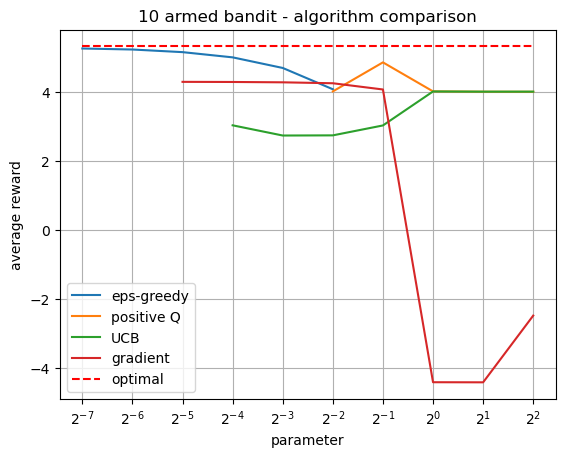

In [35]:
best_reward = np.max(q_star + np.cumsum(additional_q_star, axis=0), axis=1)[100000:]
xticks = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]

plt.plot(eps_greedy, eps_greedy_reward, label='eps-greedy')
plt.plot(positive_Q, positive_Q_reward, label='positive Q')
plt.plot(UCB, UCB_reward, label='UCB')
plt.plot(gradient, gradient_reward, label='gradient')
plt.plot(xticks, np.ones(len(xticks)) * np.mean(best_reward), 'r--', label='optimal')

plt.title('10 armed bandit - algorithm comparison')
plt.xscale('log', base=2)
plt.xticks(xticks)
plt.xlabel('parameter')
plt.ylabel('average reward')
plt.legend()
plt.grid()
plt.show()